# Construcción de Modelo Predictivo: Regresión Lineal Múltiple

Basado en el análisis inferencial previo, donde se identificaron `Battery_State_%`, `Humidity_%`, `Distance_Travelled_km` y `Driving_Mode` como variables relacionadas con `Energy_Consumption_kWh`, procederemos a construir un modelo de regresión lineal múltiple.

**Objetivo:** Predecir el consumo de energía (`Energy_Consumption_kWh`) en función de las variables seleccionadas.

**Pasos:**
1.  Preparación de datos (Selección de variables, codificación (One-Hot) y división Train/Test).
2.  Ajuste del modelo (OLS - Ordinary Least Squares).
3.  Evaluación del modelo (Métricas de error y R²).
4.  Verificación de supuestos (Linealidad, Homocedasticidad, Normalidad de residuos, Multicolinealidad).

In [1]:
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
file_path = 'EV_Energy_Consumption_Cleaned - EV_Energy_Consumption_Cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encontró.")

# Definición de variables (basado en análisis previo)
target_var = 'Energy_Consumption_kWh'
predictor_vars = ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km', 'Driving_Mode']

# Verificar que las columnas existan
missing_cols = [col for col in predictor_vars + [target_var] if col not in df.columns]
if missing_cols:
    print(f"Error: Faltan las siguientes columnas: {missing_cols}")
else:
    print(f"Variables predictoras: {predictor_vars}")
    print(f"Variable objetivo: {target_var}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset cargado correctamente.
Variables predictoras: ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km', 'Driving_Mode']
Variable objetivo: Energy_Consumption_kWh


## 1. Preparación de Datos y Ajuste del Modelo

Dividimos los datos en conjuntos de **Entrenamiento (80%)** y **Prueba (20%)**.

**Nota sobre los Modos de Conducción:**
La variable `Driving_Mode` tiene 3 categorías (1, 2, 3). Para la regresión lineal, utilizaremos **Codificación One-Hot** (Variables Dummy).
*   Se generarán dos columnas explícitas: `Driving_Mode_2` y `Driving_Mode_3`.
*   El **Modo 1** actuará como **categoría de referencia** (Base).
*   **Interpretación:** Los coeficientes de los modos 2 y 3 indicarán la diferencia de consumo respecto al Modo 1. El modelo contempla **los 3 modos**: uno en el intercepto y los otros dos como desviaciones de ese intercepto. Esto es necesario para evitar la *trampa de las variables ficticias* (multicolinealidad perfecta).

In [ ]:
# Selección de datos
X = df[predictor_vars]
y = df[target_var]

# Codificación One-Hot para variables categóricas (Driving_Mode)
# drop_first=True elimina la primera categoría (Modo 1) para usarla como referencia.
X = pd.get_dummies(X, columns=['Driving_Mode'], drop_first=True, dtype=int)

print("Variables generadas tras One-Hot Encoding:")
print(X.columns.tolist())
print("Nota: 'Driving_Mode_1' es la categoría de referencia y está capturada en el intercepto (const).")

# Añadir constante (intercepto) a X para statsmodels
X = sm.add_constant(X)

# División Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste del Modelo OLS
model = sm.OLS(y_train, X_train).fit()

# Resumen del Modelo
print(model.summary())

# Predicciones
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

                              OLS Regression Results                              
Dep. Variable:     Energy_Consumption_kWh   R-squared:                       0.291
Model:                                OLS   Adj. R-squared:                  0.290
Method:                     Least Squares   F-statistic:                     328.5
Date:                    Mon, 12 Jan 2026   Prob (F-statistic):          1.99e-295
Time:                            19:57:58   Log-Likelihood:                -8104.1
No. Observations:                    4000   AIC:                         1.622e+04
Df Residuals:                        3994   BIC:                         1.626e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## 2. Verificación de Supuestos del Modelo

Para asegurar que el modelo es válido, debemos verificar los supuestos de la regresión lineal:
1.  **Linealidad y Homocedasticidad**: Analizando los residuos vs. valores predichos.
2.  **Normalidad de los Residuos**: Usando histograma y gráfico Q-Q.
3.  **No Multicolinealidad**: Calculando el Factor de Inflación de la Varianza (VIF).

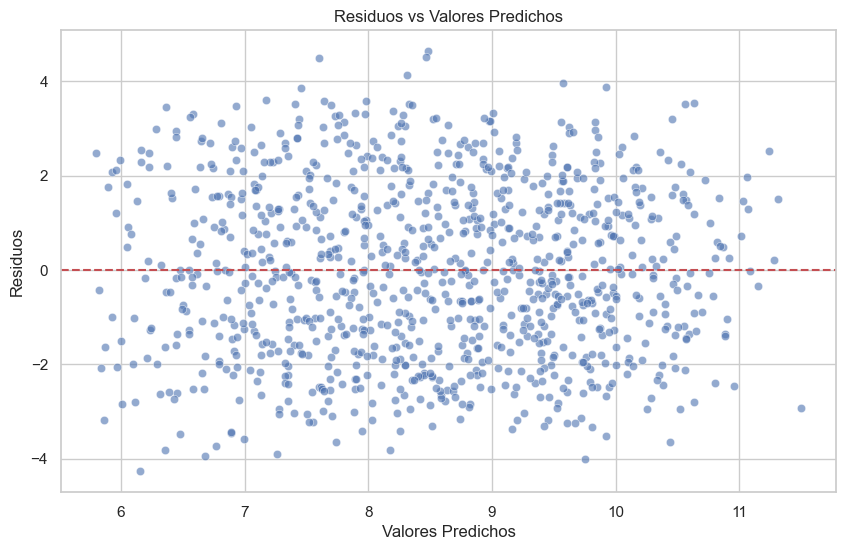

In [3]:
# 1. Linealidad y Homocedasticidad (Residuos vs Predichos)
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.show()

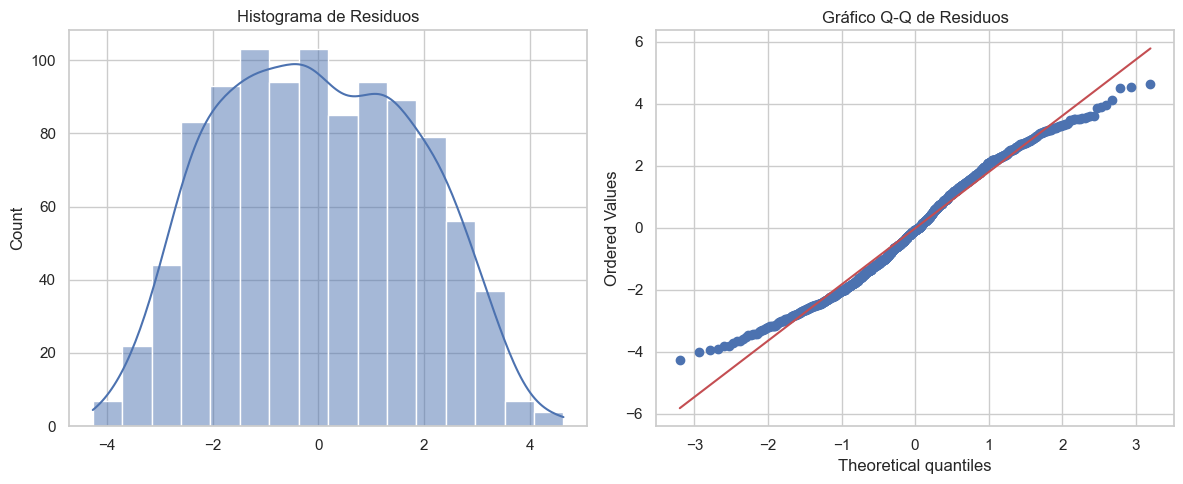

Test de Shapiro-Wilk: Estadístico=0.9829, P-valor=1.9378e-09


In [4]:
# 2. Normalidad de los Residuos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histograma de Residuos')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de Residuos')

plt.tight_layout()
plt.show()

# Test de Shapiro-Wilk para normalidad
shapiro_test = stats.shapiro(residuals)
print(f"Test de Shapiro-Wilk: Estadístico={shapiro_test.statistic:.4f}, P-valor={shapiro_test.pvalue:.4e}")

In [5]:
# 3. Multicolinealidad (VIF)
# Calcular VIF para cada variable predictora
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Factor de Inflación de la Varianza (VIF):")
print(vif_data)

Factor de Inflación de la Varianza (VIF):
                Variable        VIF
0                  const  20.263178
1        Battery_State_%   1.001465
2             Humidity_%   1.001382
3  Distance_Travelled_km   1.001099
4         Driving_Mode_2   1.355686
5         Driving_Mode_3   1.359191


## 3. Evaluación del Modelo

Calculamos las métricas de error para evaluar qué tan bien predice el modelo en datos no vistos (Test set).

In [6]:
# Métricas de Evaluación
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print("-" * 30)
print("Métricas de Desempeño (Test Set):")
print("-" * 30)
print(f"R-cuadrado (R2): {r2:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print("-" * 30)

------------------------------
Métricas de Desempeño (Test Set):
------------------------------
R-cuadrado (R2): 0.3131
RMSE (Error Cuadrático Medio): 1.8251
MAE (Error Absoluto Medio): 1.5422
------------------------------


## 4. Selección del Mejor Modelo (Criterio AIC)

Para encontrar el modelo más parsimonioso (mejor equilibrio entre ajuste y complejidad), probaremos todas las combinaciones posibles de variables predictoras y compararemos su **Criterio de Información de Akaike (AIC)**.

**Criterio:** Menor AIC indica un mejor modelo.

In [7]:
from itertools import combinations

# Variables disponibles (excluyendo la constante 'const' que añade statsmodels)
all_predictors = [col for col in X_train.columns if col != 'const']

results = []

# Probar todas las combinaciones de 1 a n variables
for k in range(1, len(all_predictors) + 1):
    for combo in combinations(all_predictors, k):
        combo_list = list(combo)
        
        # Preparar X para la combinación actual
        X_train_combo = sm.add_constant(X_train[combo_list])
        
        # Ajustar modelo
        model_combo = sm.OLS(y_train, X_train_combo).fit()
        
        # Guardar resultados
        results.append({
            'Modelo': f"Modelo {len(results)+1}",
            'Variables': ", ".join(combo_list),
            'AIC': model_combo.aic,
            'BIC': model_combo.bic,
            'R-cuadrado Adj': model_combo.rsquared_adj,
            'Num. Vars': k
        })

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Ordenar por AIC (menor es mejor)
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

# Mostrar tabla comparativa (Top 10 para brevedad si son muchas combinaciones)
print("Comparación de Modelos por AIC (Top 10):")
print("-" * 100)
print(results_df[['Modelo', 'AIC', 'BIC', 'R-cuadrado Adj', 'Variables']].head(10).to_string(index=False))
print("-" * 100)

# Destacar el mejor modelo
best_model = results_df.iloc[0]
print(f"\nMejor modelo según AIC: {best_model['Modelo']}")
print(f"Variables seleccionadas: {best_model['Variables']}")
print(f"AIC: {best_model['AIC']:.2f}")

Comparación de Modelos por AIC (Top 10):
----------------------------------------------------------------------------------------------------
   Modelo          AIC          BIC  R-cuadrado Adj                                                                          Variables
Modelo 31 16220.224979 16257.989277        0.290495 Battery_State_%, Humidity_%, Distance_Travelled_km, Driving_Mode_2, Driving_Mode_3
Modelo 16 16222.614574 16247.790773        0.289716                                 Battery_State_%, Humidity_%, Distance_Travelled_km
Modelo 26 16222.628920 16254.099168        0.289891                 Battery_State_%, Humidity_%, Distance_Travelled_km, Driving_Mode_2
Modelo 27 16223.429183 16254.899431        0.289749                 Battery_State_%, Humidity_%, Distance_Travelled_km, Driving_Mode_3
Modelo 29 16375.499673 16406.969921        0.262227             Battery_State_%, Distance_Travelled_km, Driving_Mode_2, Driving_Mode_3
Modelo 20 16379.684542 16404.860741        0.261

## 5. Recapitulación y Discusión

A continuación, se presenta un resumen consolidado del mejor modelo obtenido, incluyendo medidas de ajuste, coeficientes y una discusión crítica de los resultados.


In [8]:
# Recuperar las variables del mejor modelo identificado en el paso anterior
best_vars = best_model['Variables'].split(", ")

# Re-entrenar el modelo final usando solo las mejores variables
X_train_best = sm.add_constant(X_train[best_vars])
X_test_best = sm.add_constant(X_test[best_vars])

final_model = sm.OLS(y_train, X_train_best).fit()

# Generar predicciones finales
y_pred_final = final_model.predict(X_test_best)

# Calcular métricas finales
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_aic = final_model.aic
final_bic = final_model.bic

# Imprimir Resumen
print("="*60)
print("RECAPITULACIÓN DE RESULTADOS DEL MEJOR MODELO")
print("="*60)
print(f"Variables Predictoras Seleccionadas: {best_vars}")
print("-" * 60)
print("1. Medidas de Ajuste:")
print(f"   R² (Coeficiente de Determinación): {final_r2:.4f}")
print(f"   RMSE (Error Cuadrático Medio):     {final_rmse:.4f}")
print(f"   AIC (Criterio de Akaike):          {final_aic:.2f}")
print(f"   BIC (Criterio Bayesiano):          {final_bic:.2f}")
print("-" * 60)
print("2. Coeficientes y Significancia (P-valor < 0.05 es significativo):")
print(final_model.summary().tables[1])
print("-" * 60)
print("NOTA: La Matriz de Confusión no se incluye ya que es una métrica exclusiva")
print("para problemas de Clasificación (categorías), y este es un problema de")
print("Regresión (predicción de valores numéricos continuos).")
print("="*60)

RECAPITULACIÓN DE RESULTADOS DEL MEJOR MODELO
Variables Predictoras Seleccionadas: ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km', 'Driving_Mode_2', 'Driving_Mode_3']
------------------------------------------------------------
1. Medidas de Ajuste:
   R² (Coeficiente de Determinación): 0.3131
   RMSE (Error Cuadrático Medio):     1.8251
   AIC (Criterio de Akaike):          16220.22
   BIC (Criterio Bayesiano):          16257.99
------------------------------------------------------------
2. Coeficientes y Significancia (P-valor < 0.05 es significativo):
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.8074      0.130     52.397      0.000       6.553       7.062
Battery_State_%          -0.0212      0.001    -16.983      0.000      -0.024      -0.019
Humidity_%                0.0183      0.001     12.656      0.000  